In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
# from utils.plot_util import *
import socket
import os

In [2]:
# to have TensorFlow start out using only a minimum amount of memory and then allocate more as needed
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# # set up gpu to make sure one gpu can work for multiple scripts at the same time
# os.environ["CUDA_VISIBLE_DEVICES"]="0" # use the first gpu
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print(tf.__version__)

2.4.1


## Data Loading

In [38]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)
SAVED_IN = os.path.abspath( DIR + "/models/V27/autoencoder/")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

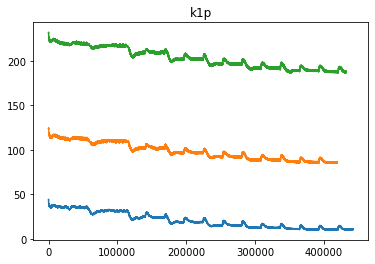

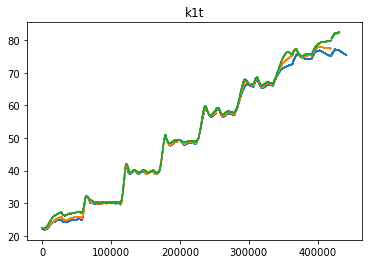

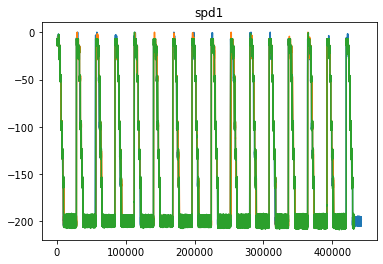

In [4]:
# load raw data and shifts
h5_p30 = h5py.File(file_list_LEM1[2], "r")
filename_p30 = file_list_LEM1[2].split(os.sep)[-1][:-3]
pklName_p30 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p30 + '.pkl'
shift_opts_freqs_all_p30 = pickle.load(open(pklName_p30, 'rb')) 

h5_p100 = h5py.File(file_list_LEM1[0], "r")
filename_p100 = file_list_LEM1[0].split(os.sep)[-1][:-3]
pklName_p100 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p100 + '.pkl'
shift_opts_freqs_all_p100 = pickle.load(open(pklName_p100, 'rb')) 

h5_p200 = h5py.File(file_list_LEM1[1], "r")
filename_p200 = file_list_LEM1[1].split(os.sep)[-1][:-3]
pklName_p200 = DIR + '/data/V27/shift_opts_freqs_all/' + filename_p200 + '.pkl'
shift_opts_freqs_all_p200 = pickle.load(open(pklName_p200, 'rb')) 


def plot3(h51,h52,h53,key):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(key)
    ax.plot(h51[key])
    ax.plot(h52[key])
    ax.plot(h53[key])
plot3(h5_p30,h5_p100,h5_p200,'k1p')
plot3(h5_p30,h5_p100,h5_p200,'k1t')
plot3(h5_p30,h5_p100,h5_p200,'spd1')

## Data Extraction

In [5]:
N = 100 # ignore first N points to make the shift possible

spd_p30 = np.round(h5_p30['spd1'][N:],decimals=1)
spd_p100 = np.round(h5_p100['spd1'][N:],decimals=1)
spd_p200 = np.round(h5_p200['spd1'][N:],decimals=1)

pos_p30 = np.round(h5_p30['pos1'][N:],decimals=1)
pos_p100 = np.round(h5_p100['pos1'][N:],decimals=1)
pos_p200 = np.round(h5_p200['pos1'][N:],decimals=1)

k1t_p30 = np.round(h5_p30['k1t'][N:],decimals=1)
k1t_p100 = np.round(h5_p100['k1t'][N:],decimals=1)
k1t_p200 = np.round(h5_p200['k1t'][N:],decimals=1)

print("shape:")
print(pos_p30.shape)
print(pos_p100.shape)
print(pos_p200.shape)
print("max:")
print(max(pos_p30))
print(max(pos_p100))
print(max(pos_p200))
print("min:")
print(min(pos_p30))
print(min(pos_p100))
print(min(pos_p200))

shape:
(441946,)
(419201,)
(431830,)
max:
124.8
124.8
124.8
min:
-135.0
-134.9
-134.9


In [6]:
s21_p30 = np.array(h5_p30['S21_P1_LEM1'])
dataset_p30 = []
for j in range (121):
    index = np.arange(N,len(h5_p30['t'])) - shift_opts_freqs_all_p30[j,N:].round().astype(int)
    dataset_p30.append(s21_p30[index,j].real)
    dataset_p30.append(s21_p30[index,j].imag)
dataset_p30 = np.array(dataset_p30)

s21_p100 = np.array(h5_p100['S21_P1_LEM1'])
dataset_p100 = []
for j in range (121):
    index = np.arange(N,len(h5_p100['t'])) - shift_opts_freqs_all_p100[j,N:].round().astype(int)
    dataset_p100.append(s21_p100[index,j].real)
    dataset_p100.append(s21_p100[index,j].imag)
dataset_p100 = np.array(dataset_p100)

s21_p200 = np.array(h5_p200['S21_P1_LEM1'])
dataset_p200 = []
for j in range (121):
    index = np.arange(N,len(h5_p200['t'])) - shift_opts_freqs_all_p200[j,N:].round().astype(int)
    dataset_p200.append(s21_p200[index,j].real)
    dataset_p200.append(s21_p200[index,j].imag)
dataset_p200 = np.array(dataset_p200)

print(dataset_p30.shape)
print(dataset_p100.shape)
print(dataset_p200.shape)

(242, 441946)
(242, 419201)
(242, 431830)


## Data Preprocessing for Autoencoder

**Pseudo code:**

for each specific position:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the indicies of themn in all three datasets and store the corresponding s21 as input of the autoencoder;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;find the s21 with chamber pressure 100 bar and mean temperature (≈ 50℃) as the output of the autoencoder and store them;
    
    
    

In [7]:
MAX = min(max(pos_p30),max(pos_p100),max(pos_p200))
MIN = max(min(pos_p30),min(pos_p100),min(pos_p200))

In [27]:
# # test for a specific p
# p = 0
# ind_p30 = np.where(pos_p30==p)[0]
# ind_p100 = np.where(pos_p100==p)[0]
# ind_p200 = np.where(pos_p200==p)[0]
# L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]

# # indicies with chamber pressure 100 and temperature in the range of [48,52]
# ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52))[0]

# # randomly choose one point as the ground choo
# GT = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
    
# x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
# y_auto_ = np.array(L * [dataset_p100[:,GT]]) # shape (L,242)


0.0041383468

In [9]:
np.random.seed(42)
x_auto = []
y_auto = []

for p in np.arange(MIN,MAX+0.1,0.1):
    p = np.round(p,decimals=1)
    ind_p30 = np.where(pos_p30==p)[0]
    ind_p100 = np.where(pos_p100==p)[0]
    ind_p200 = np.where(pos_p200==p)[0]
    
    if ind_p30.size == 0:
        print("There is no data with position {} in dataset_p30".format(p))
        continue
    if ind_p100.size == 0:
        print("There is no data with position {} in dataset_p100".format(p))
        continue
    if ind_p200.size == 0:
        print("There is no data with position {} in dataset_p200".format(p))
        continue
        
    L = ind_p30.shape[0] + ind_p100.shape[0] + ind_p200.shape[0]
    
    try:
        # indicies with chamber pressure 100 and temperature in the range of [48,52]
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=48, k1t_p100<=52))[0]
    
        # randomly choose one point as the ground choo
        GT = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        
    except:
        print ("Search range of GT has to be extended for position {}".format(p))
        # indicies with chamber pressure 100 and temperature in the range of [45,55]
        ind_p100_t50 = np.where(np.logical_and(k1t_p100>=45, k1t_p100<=55))[0]
        # randomly choose one point as the ground choo
        GT = np.random.choice(np.intersect1d(ind_p100_t50,ind_p100))
        print ("We have to use the temperature {} instead\n".format(k1t_p100[GT]))
        
    x_auto_ = np.concatenate((dataset_p30[:,ind_p30],dataset_p100[:,ind_p100],dataset_p200[:,ind_p200]),axis=1) # shape (242,L)
    y_auto_ = np.array(L * [dataset_p100[:,GT]]) # shape (L,242)
    
    x_auto.append(x_auto_.T)
    y_auto.append(y_auto_)
    
x_auto = np.vstack(x_auto)
y_auto = np.vstack(y_auto)

print("shapes")
print(x_auto.shape)
print(y_auto.shape)

Search range of GT has to be extended for position -23.2
We have to use the temperature 52.6 instead

Search range of GT has to be extended for position -19.3
We have to use the temperature 47.6 instead

shapes
(1292976, 242)
(1292976, 242)


In [37]:
mae = losses.MeanAbsoluteError()
print("original MAE {}".format(mae(x_auto,y_auto).numpy()))

original MAE 0.032709043473005295


### Train test split

In [10]:
from sklearn.model_selection import train_test_split

x_auto_train, x_auto_test, y_auto_train, y_auto_test,= train_test_split(x_auto, y_auto, test_size=0.2, random_state=42)

print(x_auto_train.shape)
print(x_auto_test.shape)

(1034380, 242)
(258596, 242)


### Normalize the data to [0,1]

mean, max, min based on x_auto_train or y_auto_train?

In [11]:
min_val = tf.reduce_min(x_auto_train)
max_val = tf.reduce_max(x_auto_train)

x_auto_train = (x_auto_train - min_val) / (max_val - min_val)
x_auto_test = (x_auto_test - min_val) / (max_val - min_val)
y_auto_train = (y_auto_train - min_val) / (max_val - min_val)
y_auto_test = (y_auto_test - min_val) / (max_val - min_val)

x_auto_train = tf.cast(x_auto_train, tf.float32)
x_auto_test = tf.cast(x_auto_test, tf.float32)
y_auto_train = tf.cast(y_auto_train, tf.float32)
y_auto_test = tf.cast(y_auto_test, tf.float32)

## Autoencoder

In [40]:
MODEL_NAME = "autoencoder_baseline" 

In [12]:
class AutoEncoder_Baseline(Model):
  def __init__(self):
    super(AutoEncoder_Baseline, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(242, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

autoencoder = AutoEncoder_Baseline()

autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(x_auto_train,y_auto_train, 
          epochs=20, 
          batch_size=512,
          validation_data=(x_auto_test, y_auto_test),
          callbacks=[callback],
          shuffle=True)

Epoch 1/20
2021/2021 [==============================] - 7s 3ms/step - loss: 0.0245 - val_loss: 0.0162
Epoch 2/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 3/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 4/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 5/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 6/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 7/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0153 - val_loss: 0.0154
Epoch 8/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 9/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 10/20
2021/2021 [==============================] - 7s 4ms/step - loss: 0.015

In [41]:
autoencoder.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\autoencoder\autoencoder_baseline\assets


In [ ]:
# MODEL_NAME = "autoencoder_baseline" 
# autoencoder = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

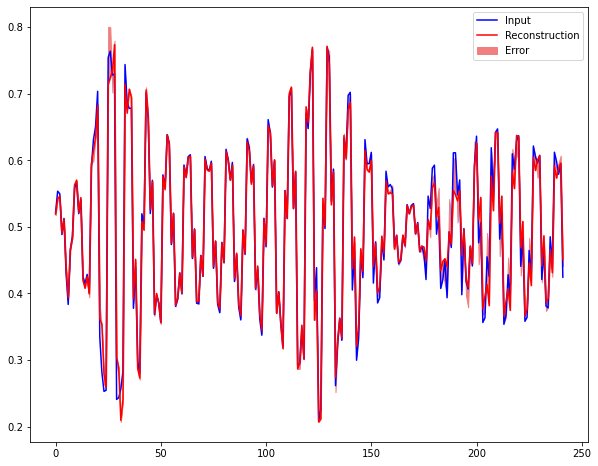

In [36]:
SAMPLE = 35138

encoded_imgs = autoencoder.encoder(x_auto_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(10,8))
plt.plot(x_auto_test[SAMPLE], 'b')
plt.plot(decoded_imgs[SAMPLE], 'r')
plt.fill_between(np.arange(242), decoded_imgs[SAMPLE], y_auto_test[SAMPLE], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Training based on decoded imgs